# Practice 1. Cross Validation

Do together

In [1]:
import gc
import os
import math
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns

## Quick Data Treatment

In [2]:
df_train = pd.read_csv('data/kalapa-credit-score/train.csv')
df_test = pd.read_csv('data/kalapa-credit-score/test.csv')

In [3]:
y_train, y_test = df_train['label'], df_train['label']

In [4]:
### Data cleaning

In [5]:
def clean_df(df):
    df = df.drop(columns=["id"])
    # Convert value     
    df['FIELD_8'] = df.FIELD_8.replace('MALE',1).replace('FEMALE',2)
    df['FIELD_35'] = df.FIELD_35.replace('Zero',0).replace('One',1).replace('Two',2).replace('Three',3).replace('Four',4)
    df['FIELD_41'] = df.FIELD_41.replace('I',1).replace('II',2).replace('II',3).replace('IV',4).replace('V',5)
    df['FIELD_44'] = df.FIELD_44.replace('One',1).replace('Two',2)
    df = df.replace("True", True).replace("False", False)
    # Remove null     
    df.fillna(value=0,inplace=True)
    df = df.replace("None", 0)
    # Convert types
    df = df.infer_objects()
    df = df.select_dtypes(exclude=['object'])
    return df

In [6]:
df_train = clean_df(df_train)
df_test = clean_df(df_test)

In [7]:
# X_scaled_train = X_scaled_train.drop(columns=["label"])

### Split Data and normalize

Normalize the data X (optional)

In [8]:
# scaler = StandardScaler()
# scaler.fit(X)
# X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [9]:
y = df_train['label']
X = df_train.copy()
X = X.drop(columns='label')

In [10]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [11]:
X_scaled_train.shape, X_scaled_test.shape

((24000, 31), (6000, 31))

## Train with Train/test split

This function is to show which featuree is important

In [12]:
params = {
          'n_estimators': 5000,
          'num_leaves': 6,
          'min_data_in_leaf': 2,
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting": "gbdt",
          "bagging_freq": 10,
          'num_threads': 8,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
          "metric": 'binary_logloss',
         }

In [13]:
def plot_feature_importance(feature_importance,title):
    fe = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)
    fe['feature'] = fe.index
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=fe)
    plt.xticks([])
    plt.title(title)
    return

In [14]:
def train_lgb(X_train, X_valid, y_train, y_valid, params=None):

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc', 'binary_logloss'],
            verbose=0, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    print('Train AUC:',roc_auc_score(y_train, y_pred_train))
    print('Valid AUC:',roc_auc_score(y_valid, y_pred_valid))
        
    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance, model

In [15]:
y_pred_train, y_pred_valid, importance, _ = train_lgb(X_scaled_train, X_scaled_test, y_train, y_test, params)

Train AUC: 0.5
Valid AUC: 0.5


## Train with Cross-Validation

In [16]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=100)
# Shuffle sould be true
# But if time series, for example, don't shuffle
# Kfold: split into k fold randomly
# StratifiedFold : idem, butnumber of each classes are well distributed between folds

# When data is unbalanced --> always Stratfold

In [17]:
def train_fold_lgb(X, y, params=None,folds=folds):
    oof = np.zeros(len(X))
    all_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Train Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print('Fold sizes: ', X_train.shape, X_valid.shape)
        
        y_pred_train, y_pred_valid, fold_importance, lgb_model = train_lgb(X_train, X_valid, y_train, y_valid, params)

        # Save model in file
        filename = f"lgb_{fold_n}.txt"
        lgb_model.booster_.save_model(filename)
        
        print("Model saved in ", filename)
        
        # Add Fold prediction to Out-Of-Fold Prediction
        oof[valid_index] = y_pred_valid.reshape(-1,)
        
        # Add Fold importance to overal importance
        fold_importance["fold"] = fold_n + 1
        all_importance = pd.concat([all_importance, fold_importance], axis=0)
        print('====================================')
    print('Final result of Out-Of-Fold:')
    print('OOF AUC:',roc_auc_score(y, oof))
        
    return oof, all_importance

In [18]:
oof, feature_importance = train_fold_lgb(X_scaled_train, y_train, params=params)

Train Fold 0 started at Thu Apr 16 14:19:08 2020
Fold sizes:  (19200, 31) (4800, 31)
Train AUC: 0.5
Valid AUC: 0.5
Model saved in  lgb_0.txt
Train Fold 1 started at Thu Apr 16 14:19:09 2020
Fold sizes:  (19200, 31) (4800, 31)
Train AUC: 0.5
Valid AUC: 0.5
Model saved in  lgb_1.txt
Train Fold 2 started at Thu Apr 16 14:19:11 2020
Fold sizes:  (19200, 31) (4800, 31)
Train AUC: 0.5
Valid AUC: 0.5
Model saved in  lgb_2.txt
Train Fold 3 started at Thu Apr 16 14:19:13 2020
Fold sizes:  (19200, 31) (4800, 31)
Train AUC: 0.5
Valid AUC: 0.5
Model saved in  lgb_3.txt
Train Fold 4 started at Thu Apr 16 14:19:17 2020
Fold sizes:  (19200, 31) (4800, 31)
Train AUC: 0.5
Valid AUC: 0.5
Model saved in  lgb_4.txt
Final result of Out-Of-Fold:
OOF AUC: 0.5


Plot the feature importance

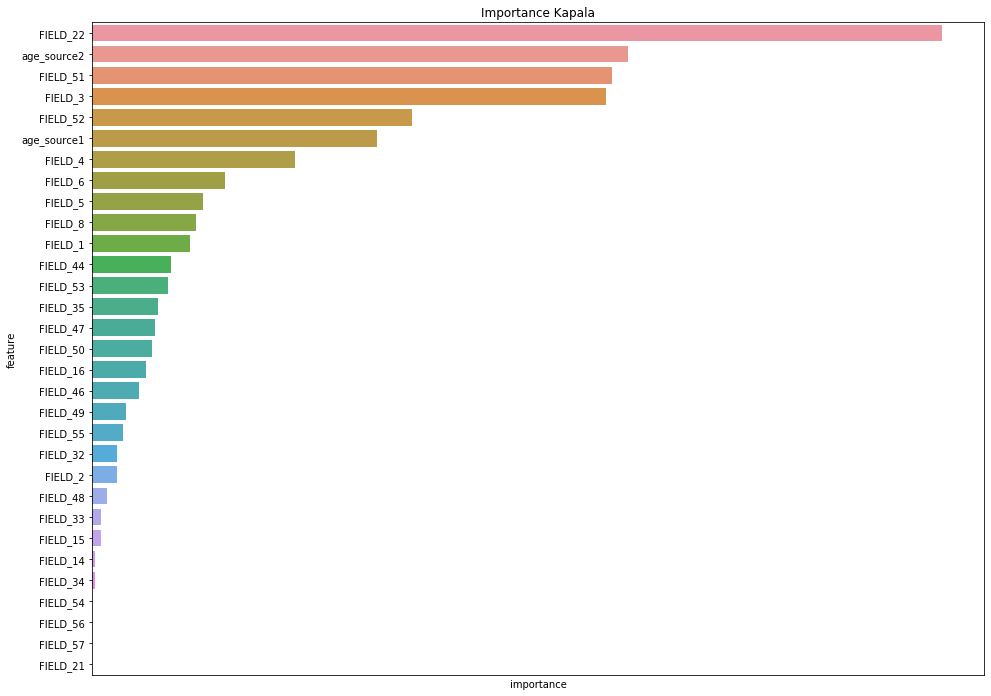

In [19]:
plot_feature_importance(feature_importance, title = 'Importance Kapala')

In [20]:
feature_importance

,feature,importance,fold
0,age_source1,0,1
1,age_source2,3,1
2,FIELD_1,0,1
3,FIELD_2,0,1
4,FIELD_3,0,1
5,FIELD_4,2,1
6,FIELD_5,2,1
7,FIELD_6,0,1
8,FIELD_8,0,1
9,FIELD_14,0,1


In [21]:
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)

In [22]:
feature_importance

,feature,importance,fold
13,FIELD_22,107,4
4,FIELD_3,80,4
13,FIELD_22,64,5
24,FIELD_51,63,4
13,FIELD_22,58,3
1,age_source2,58,5
1,age_source2,55,4
4,FIELD_3,54,5
24,FIELD_51,46,3
24,FIELD_51,46,5


In [23]:
important_columns = feature_importance["feature"].unique()[:10]
# important_columns = np.append(important_columns, "label")

In [24]:
small_df_train = df_train[important_columns].sample(1000)
small_df_test = df_test[important_columns].sample(1000)

In [25]:
small_df_train.to_csv('small_kalapa_train.csv', index=False)
small_df_test.to_csv('small_kalapa_test.csv', index=False)

## Other models

#### Neural network

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization


Using TensorFlow backend.


In [41]:
def train_nn(X_train, X_valid, y_train, y_valid):
    
    
    # Create a model
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
             )
    
    # Train model and predict on valid

    model.fit(X_train, y_train,
              epochs=200,
              batch_size=32,
              verbose=0)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    # Print acc
    print('Train AUC:',roc_auc_score(y_train, y_pred_train))
    print('Valid AUC:',roc_auc_score(y_valid, y_pred_valid))
        
    return y_pred_train, y_pred_valid, model

In [42]:
_, _, _ = train_nn(X_scaled_train, X_scaled_test, y_train, y_test)

KeyboardInterrupt: 

In [ ]:
def train_fold_nn(X, y, folds=folds):
    oof = np.zeros(len(X))
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Train Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print('Fold sizes: ', X_train.shape, X_valid.shape)
        
        y_pred_train, y_pred_valid, nn_model = train_nn(X_train, X_valid, y_train, y_valid)
        
        # Save model in file
        
        filename = f"nn_{fold_n}.txt"
        nn_model.save(filename)
        print('Model saved in ', filename)
        
        # Add Fold prediction to Out-Of-Fold Prediction
        oof[valid_index] = y_pred_valid.reshape(-1,)
        
        print('====================================')
    print('Final result of Out-Of-Fold:')
    print('OOF AUC:',roc_auc_score(y, oof))
        
    return oof

In [ ]:
oof = train_fold_nn(X_scaled_train, y_train)

In [ ]:
test_pred = []
for i in range (n_fold):
    print("Test fold : ", i)
    model = lgb.Booster(model_file = "lgb_" + str(i) + ".txt")
    y_pred_test = model.predict(X_scaled_test)
    print("Test AUC : ", roc_auc_score(y_test, y_pred_test))
    test_pred.append(y_pred_test)

In [ ]:
z = np.array(test_pred)

In [ ]:
final_test = np.mean(z, axis = 0)

In [ ]:
print("Final test AUC: ", roc_auc_score(y_test, final_test))

In [ ]:
from keras.models import load_model

In [ ]:
test_pred = []
for i in range (n_fold):
    print("Test fold : ", i)
    model = load_model("nn_" + str(i) + ".txt")
    y_pred_test = model.predict(X_scaled_test)
    print("Test AUC : ", roc_auc_score(y_test, y_pred_test))
    test_pred.append(y_pred_test)

In [ ]:
z = np.array(test_pred)

In [ ]:
final_test = np.mean(z, axis = 0)

In [ ]:
print("Final test AUC: ", roc_auc_score(y_test, final_test))

### Sklearn models

#### Linear model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.externals import joblib

In [ ]:
def train_linear(X_train, X_valid, y_train, y_valid):
    
    
    # Create a model
    model = LinearRegression()
    
    # Train model and predict on valid

    model.fit(X_train, y_train,)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    # Print acc
    print('Train AUC:',roc_auc_score(y_train, y_pred_train))
    print('Valid AUC:',roc_auc_score(y_valid, y_pred_valid))
        
    return y_pred_train, y_pred_valid, model

In [ ]:
_, _, _ = train_linear(X_scaled_train, X_scaled_test, y_train, y_test)

In [ ]:
def train_fold_linear(X, y, folds=folds):
    oof = np.zeros(len(X))
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Train Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print('Fold sizes: ', X_train.shape, X_valid.shape)
        
        y_pred_train, y_pred_valid, linear_model = train_linear(X_train, X_valid, y_train, y_valid)
        
        # Save model in file
        filename = f"linear_{fold_n}.txt"
        joblib.dump(linear_model, filename) 
        print("Model saved in ", filename)
        
        # Add Fold prediction to Out-Of-Fold Prediction
        oof[valid_index] = y_pred_valid.reshape(-1,)
        
        print('====================================')
    print('Final result of Out-Of-Fold:')
    print('OOF AUC:',roc_auc_score(y, oof))
        
    return oof

In [ ]:
oof = train_fold_linear(X_scaled_train, y_train)

In [ ]:
test_pred = []
for i in range (n_fold):
    print("Test fold : ", i)
    model = joblib.load("linear_" + str(i) + ".txt")
    y_pred_test = model.predict(X_scaled_test)
    print("Test AUC : ", roc_auc_score(y_test, y_pred_test))
    test_pred.append(y_pred_test)

In [ ]:
z = np.array(test_pred)
final_test = np.mean(z, axis = 0)
print("Final test AUC: ", roc_auc_score(y_test, final_test))

#### SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
def train_svc(X_train, X_valid, y_train, y_valid):
    
    
    # Create a model
    model = SVC()
    
    # Train model and predict on valid

    model.fit(X_train, y_train,)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    # Print acc
    print('Train AUC:',roc_auc_score(y_train, y_pred_train))
    print('Valid AUC:',roc_auc_score(y_valid, y_pred_valid))
        
    return y_pred_train, y_pred_valid, model

In [ ]:
_, _, _ = train_svc(X_scaled_train, X_scaled_test, y_train, y_test)

In [ ]:
def train_fold_svc(X, y, folds=folds):
    oof = np.zeros(len(X))
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Train Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print('Fold sizes: ', X_train.shape, X_valid.shape)
        
        y_pred_train, y_pred_valid, linear_model = train_svc(X_train, X_valid, y_train, y_valid)
        
        # Save model in file
        filename = f"svc_{fold_n}.txt"
        joblib.dump(linear_model, filename) 
        print("Model saved in ", filename)
        
        # Add Fold prediction to Out-Of-Fold Prediction
        oof[valid_index] = y_pred_valid.reshape(-1,)
        
        print('====================================')
    print('Final result of Out-Of-Fold:')
    print('OOF AUC:',roc_auc_score(y, oof))
        
    return oof

In [ ]:
oof = train_fold_nn(X_scaled_train, y_train)

In [ ]:
test_pred = []
for i in range (n_fold):
    print("Test fold : ", i)
    model = joblib.load("svc_" + str(i) + ".txt")
    y_pred_test = model.predict(X_scaled_test)
    print("Test AUC : ", roc_auc_score(y_test, y_pred_test))
    test_pred.append(y_pred_test)

In [ ]:
z = np.array(test_pred)
final_test = np.mean(z, axis = 0)
print("Final test AUC: ", roc_auc_score(y_test, final_test))